In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

%matplotlib notebook

register_matplotlib_converters()

In [60]:
# 从 Yahoo Finance 下载历史数据

tickers = [
    'SPY',   # S&P500 ETF
    'IEF',   # 7-10 year US treasury bond ETF
    'AAPL',  # Apple stock
]

data = yf.download(
    tickers = tickers,
    period = 'max',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

# download SSE Composite Index separately 
# because data of this index on Yahoo finance is incomplete
ssec_data = yf.download(
    tickers = '^SSEC',
    period = 'max',
    interval = '1d',
    group_by = 'ticker',
    auto_adjust = True,
    prepost = True).dropna()

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>


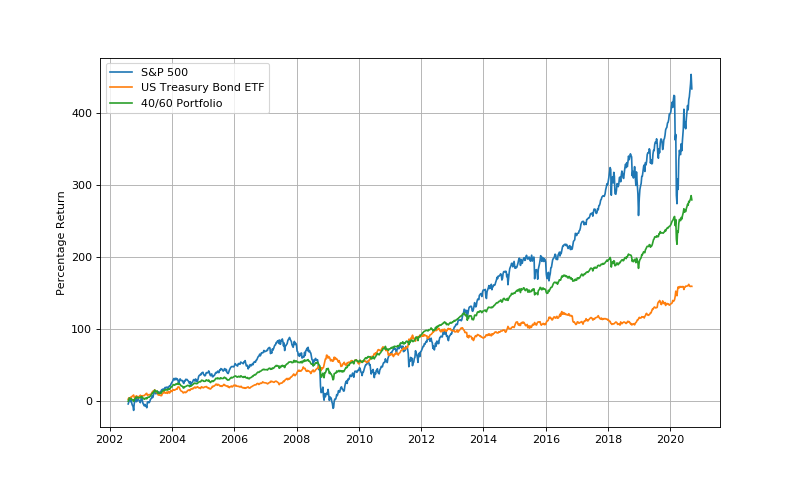

In [61]:
sp500 = data['SPY']['Close'].to_numpy()
bond= data['IEF']['Close'].to_numpy()

# 计算 5 个交易日的累计收益
sp500_wk = sp500[::5]
bond_wk = bond[::5]
sp500_wk_ret = sp500_wk[1:]/sp500_wk[:-1]
bond_wk_ret = bond_wk[1:]/bond_wk[:-1]

index_wk = data.index[::5]
index_wk = index_wk[1:]

assert(len(index_wk)==len(bond_wk_ret))

# 构建 40/60 组合的收益，每 5 个交易日调仓一次，交易成本忽略不计
portfolio_ret = 0.4 * sp500_wk_ret + 0.6 * bond_wk_ret

fig1 = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(index_wk, (np.cumprod(sp500_wk_ret)-1)*100, color='C0')
ax.plot(index_wk, (np.cumprod(bond_wk_ret)-1)*100, color='C1')
ax.plot(index_wk, (np.cumprod(portfolio_ret)-1)*100, color='C2')
ax.legend(['S&P 500', 'US Treasury Bond ETF', '40/60 Portfolio'])
ax.set_ylabel('Percentage Return')
ax.grid()

<IPython.core.display.Javascript object>


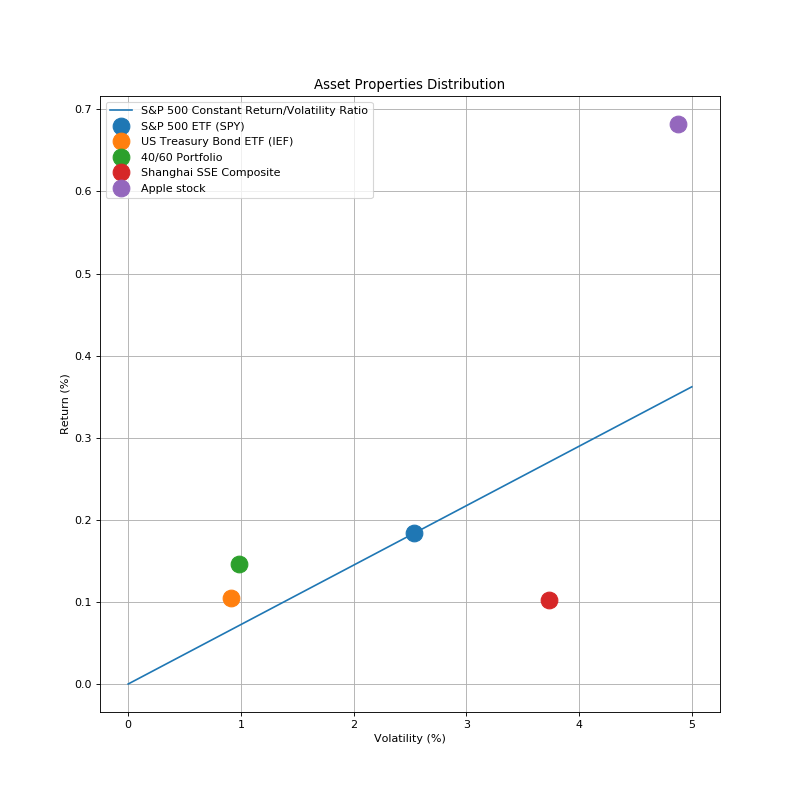

Text(0, 0.5, 'Return (%)')

In [76]:

# 计算每周收益率的平均值与标准差
def ComputeReturnAndVolatility(data, method='vanilla'):

    if method=='vanilla':
        # 简单的定性分析，这样计算问题不太大
        mean = np.mean(data - 1) * 100
        sigma = np.std(data - 1) * 100
        
    elif method=='log':
        # 更严谨的计算需要用到对数。
        # 因为累积收益率是要用乘法而不是加法。对数可以将乘法变换成加法。
        mean = (np.exp(np.mean(np.log(data))) - 1) * 100
        sigma = (np.exp(np.std(np.log(data))) - 1) * 100
        
    else:
        raise TypeError('Invalid method, must be \'vanilla\' or \'log\'') 

    return mean, sigma

ssec = ssec_data['Close'].to_numpy()
ssec_wk = ssec[::5]
ssec_wk_ret = ssec_wk[1:]/ssec_wk[:-1]

apple = data['AAPL']['Close'].to_numpy()
apple_wk = apple[::5]
apple_wk_ret = apple_wk[1:]/apple_wk[:-1]

# 指定计算方法，这里用更严谨的对数方法。
method = 'log'

ssec_ret_mean, ssec_ret_sigma = ComputeReturnAndVolatility(ssec_wk_ret, method=method)
sp500_ret_mean, sp500_ret_sigma = ComputeReturnAndVolatility(sp500_wk_ret, method=method)
bond_ret_mean, bond_ret_sigma = ComputeReturnAndVolatility(bond_wk_ret, method=method)
portfolio_ret_mean, portfolio_ret_sigma = ComputeReturnAndVolatility(portfolio_ret, method=method)
apple_ret_mean, apple_ret_sigma = ComputeReturnAndVolatility(apple_wk_ret, method=method)

sp500_line_x = np.linspace(0, 5, 5)
sp500_line_y = sp500_line_x * sp500_ret_mean / sp500_ret_sigma

fig1 = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.plot(sp500_line_x, sp500_line_y, color='C0')
ax.plot(sp500_ret_sigma, sp500_ret_mean, '.', color='C0', markersize=30)
ax.plot(bond_ret_sigma, bond_ret_mean, '.', color='C1', markersize=30)
ax.plot(portfolio_ret_sigma, portfolio_ret_mean, '.', color='C2', markersize=30)
ax.plot(ssec_ret_sigma, ssec_ret_mean, '.', color='C3', markersize=30)
ax.plot(apple_ret_sigma, apple_ret_mean, '.', color='C4', markersize=30)
ax.legend(['S&P 500 Constant Return/Volatility Ratio', 
           'S&P 500 ETF (SPY)', 
           'US Treasury Bond ETF (IEF)', 
           '40/60 Portfolio', 
           'Shanghai SSE Composite', 
           'Apple stock'])

ax.grid()
ax.set_title('Asset Properties Distribution')
ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Return (%)')

<IPython.core.display.Javascript object>


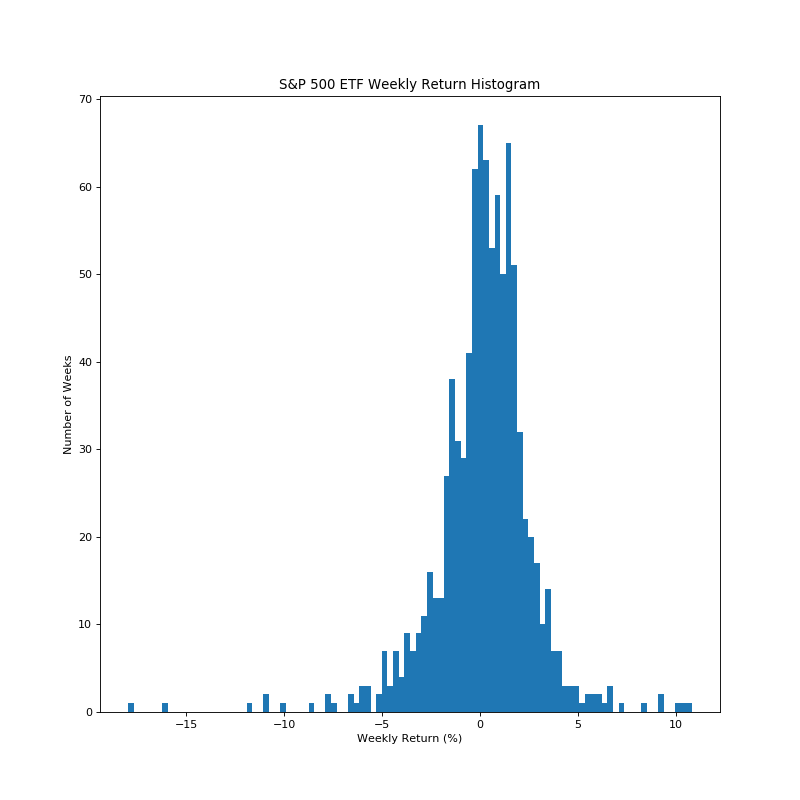

In [71]:
fig1 = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig1.add_subplot(1,1,1)
ax.hist((sp500_wk_ret-1) * 100, bins=100)
ax.set_title('S&P 500 ETF Weekly Return Histogram')
ax.set_xlabel('Weekly Return (%)')
ax.set_ylabel('Number of Weeks')
plt.show()